<a href="https://colab.research.google.com/github/sthalles/logistic-regression/blob/master/Binary_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from numpy.linalg import pinv, inv
import matplotlib.pyplot as plt

In [0]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
    #print(self.valid_classes)
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data, targets)
    
    total = 0
    for i in self.data.keys():
      print("Class {0} # of records: {1}".format(i,len(self.data[i])))
      total += len(self.data[i])
    print("Total:",total)
    
  def to_dict(self, data, targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())

    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict

  def get_data_by_class(self, class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise ("Class not found.")

  def get_data_as_dict(self):
    return self.data

  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, np.expand_dims(labels,1)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_dataset = DataSet(x_train, y_train, valid_classes=[0,1])
inputs, targets = train_dataset.get_all_data()

test_dataset = DataSet(x_test, y_test, valid_classes=[0,1])
test_inputs, test_targets = test_dataset.get_all_data()

Class 0 # of records: 5923
Class 1 # of records: 6742
Total: 12665
Class 1 # of records: 1135
Class 0 # of records: 980
Total: 2115


In [5]:
print("inputs shape:",inputs.shape)
print("targets shape:",targets.shape)

inputs shape: (12665, 784)
targets shape: (12665, 1)


- For an M-dimensional feature space φ, this model has M adjustable parameters


In [0]:
def generate_R(predictions):
  # N × N diagonal matrix R with elements Rnn = yn(1−yn)
  R = np.zeros((predictions.shape[0],predictions.shape[0]))
  for i in range(R.shape[0]):
    #print(predictions[i])
    R[i][i] = predictions[i] * (1-predictions[i])
  return R

def hessian(x,R):
  return np.dot(x.T,np.dot(R,x))
    
def grad(y,t,x):
  # y: models predictions (Batch,)
  # t: dataset targets (Batch,)
  return np.dot(x.T, (y - t))
  
  
class LogisticRegression:
  def __init__(self,fit_intercept=True):
    self.fit_intercept = fit_intercept
    self.W = None
    
  
  def predict(self,x,y,threshold=0.5):
    if self.fit_intercept:
      x = self.add_intercept(x)    
      
    logits = self.forward(x)
    predictions = [1 if t >= threshold else 0 for t in logits]
    return predictions
  
  def score(self,x,y):
    predictions = self.predict(x,y)
    return np.sum(np.squeeze(predictions) == np.squeeze(y)) / len(y)

  def sigmoid(self,x):
    # Under rather general assumptions, the posterior probability of class C1 can be written 
    # as a logistic sigmoid acting on a linear function of the feature vector φ so that
    return 1. / (1. + np.exp(-x))
    
  def forward(self,x):
    
    if self.W is None:
      self.W = np.full((x.shape[1],1), 0.01) #np.random.rand(x.shape[1],1)
      
    linear = np.dot(x,self.W)
    return self.sigmoid(linear) # the order dot(x,W) seems correct

  def add_intercept(self,x):
    # generate a NxM design matrix, with an added column of 1
    const = np.ones((x.shape[0],1))
    return np.concatenate((const,x),axis=1)

  def fit(self,x,y,iterations=2):
    
    if self.fit_intercept:
      x = self.add_intercept(x)
      
    for i in range(iterations):
      predictions = self.forward(x)
      R = generate_R(predictions)
      H = hessian(x,R)
      print("Hessian:",H.shape)
      gradients = grad(predictions,y,x)
      invH = pinv(H)
      #W_new = self.W - 0.2 * gradients
      self.W = self.W - np.dot(invH, gradients)

In [0]:
clf = LogisticRegression(fit_intercept=True)

- Uses the Newton-Raphson iterative optimization scheme to optimize the values of W

In [8]:
clf = LogisticRegression(fit_intercept=True)
clf.fit(inputs,targets)

Hessian: (785, 785)
Hessian: (785, 785)


In [9]:
acc = clf.score(inputs,targets)
print(acc)

0.9996052112120016


In [10]:
acc = clf.score(test_inputs,test_targets)
print(acc)

0.9985815602836879


## Evaluating Binary Classifier

In [0]:
# Compute True positives, True negatives, False positives and False negatives
predictions = clf.predict(test_inputs,test_targets)

In [0]:
def get_accuracy_params(predictions, targets):

  TP=FP=TN=FN=0
  for pred, target in zip(predictions,targets):
    if pred == 1:
      if pred == target:
        TP += 1
      else:
        FP += 1
    else: # pred == 0:
      if pred == target:
        TN += 1
      else:
        FN += 1
  return TP, FP, TN, FN

#print("True Positives TP: {0}\nFalse Positives FP: {1}\nFalse Negatives FN: {2}\nTrue Negatives TN: {3}".format(TP,FP,FN,TN))

In [13]:
TP, FP, TN, FN = get_accuracy_params(predictions,test_targets)
print(TP, FP, TN, FN)

# ratio of true positives
precision = TP / (TP + FP)

# true positive ratio
recall = TP / (TP + FN)

print("Precision:",precision)
print("Recall:",recall)

1134 2 978 1
Precision: 0.9982394366197183
Recall: 0.9991189427312775


In [0]:
thresholds = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
TPRs = []
FPRs = []
for t in thresholds:
  predictions = clf.predict(test_inputs, test_targets, threshold=t)
  TP, FP, TN, FN = get_accuracy_params(predictions,test_targets)
  TPR = TP / (TP + FN) # recall
  FPR = FP / (FP + TN) # false positive rate
  TPRs.append(TPR)
  FPRs.append(FPR)

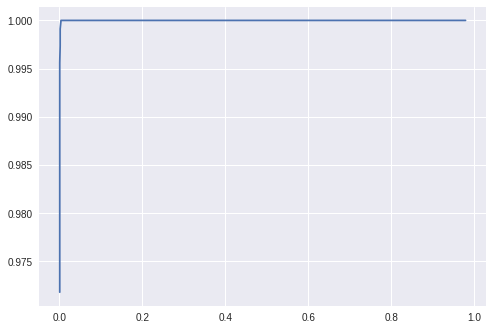

In [15]:
plt.plot(FPRs,TPRs)
plt.show()